## Request and Store Latest Base Reflectivity 

For site KHNX

In [11]:
from awips.dataaccess import DataAccessLayer
from awips import ThriftClient, RadarCommon
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from dynamicserialize.dstypes.com.raytheon.uf.common.dataplugin.radar.request import GetRadarDataRecordRequest
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from metpy.plots import ctables
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# set EDEX server and radar site definitions
site = 'khnx'
DataAccessLayer.changeEDEXHost('edex-cloud.unidata.ucar.edu')
request = DataAccessLayer.newDataRequest()
request.setDatatype('radar')
request.setLocationNames(site)

# Get latest time for site
datatimes = DataAccessLayer.getAvailableTimes(request)
dateTimeStr = str(datatimes[-1])
buffer = 60 
dateTime = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S')
beginRange = dateTime - timedelta(0, buffer)
endRange = dateTime + timedelta(0, buffer)
timerange = TimeRange(beginRange, endRange)

# GetRadarDataRecordRequest to query site with timerange
client = ThriftClient.ThriftClient('edex-cloud.unidata.ucar.edu')
request = GetRadarDataRecordRequest()
request.setTimeRange(timerange)
request.setRadarId(site)

# Map config
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12, 12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

nexrad = {}
nexrad["N0Q"] = {
    'id': 94, 
    'unit':'dBZ', 
    'name':'0.5 deg Base Reflectivity', 
    'ctable': ['NWSStormClearReflectivity',-20., 0.5], 
    'res': 1000.,
    'elev': '0.5'
}
grids = []
for code in nexrad:
    request.setProductCode(nexrad[code]['id'])
    request.setPrimaryElevationAngle(nexrad[code]['elev'])
    response = client.sendRequest(request)
    
    if response.getData():
        for record in response.getData():
            # Get record hdf5 data
            idra = record.getHdf5Data()
            rdat,azdat,depVals,threshVals = RadarCommon.get_hdf5_data(idra)
            dim = rdat.getDimension()
            lat,lon = float(record.getLatitude()),float(record.getLongitude())
            radials,rangeGates = rdat.getSizes()
            
            # Convert raw byte to pixel value
            rawValue=np.array(rdat.getByteData())
            array = []
            for rec in rawValue:
                if rec<0:
                    rec+=256
                array.append(rec)
                
            if azdat:
                azVals = azdat.getFloatData()
                az = np.array(RadarCommon.encode_radial(azVals))
                dattyp = RadarCommon.get_data_type(azdat)
                az = np.append(az,az[-1])

            header = RadarCommon.get_header(record, format, rangeGates, radials, azdat, 'description')
            rng = np.linspace(0, rangeGates, rangeGates + 1)

            # Convert az/range to a lat/lon
            from pyproj import Geod
            g = Geod(ellps='clrk66')
            center_lat = np.ones([len(az),len(rng)])*lat   
            center_lon = np.ones([len(az),len(rng)])*lon
            az2D = np.ones_like(center_lat)*az[:,None]
            rng2D = np.ones_like(center_lat)*np.transpose(rng[:,None])*nexrad[code]['res']
            lons,lats,back=g.fwd(center_lon,center_lat,az2D,rng2D)
            bbox = [lons.min(), lons.max(), lats.min(), lats.max()]
            
            # Create 2d array
            multiArray = np.reshape(array, (-1, rangeGates))
            data = ma.array(multiArray)
            
            # threshVals[0:2] contains halfwords 31,32,33 (min value, increment, num levels)
            data = ma.array(threshVals[0]/10. + (multiArray)*threshVals[1]/10.)
            
            if nexrad[code]['unit'] == 'kts':
                data[data<-63] = ma.masked
                data *= 1.94384 # Convert to knots
            else:
                data[data<=((threshVals[0]/10.)+threshVals[1]/10.)] = ma.masked
            
            # Save our requested grids so we can render them multiple times
            product = {
                "code": code,
                "bbox": bbox,
                "lats": lats,
                "lons": lons,
                "data": data
            }
            grids.append(product)
            
print("Processed "+str(len(grids))+" grid.")

Processed 1 grid.


## Request Recent NWS Warnings

In [13]:
request = DataAccessLayer.newDataRequest()
request.setDatatype("warning")
request.setParameters('act','countyheader', 'endtime','etn','floodbegin', 
                      'floodcrest', 'floodend','floodrecordstatus', 
                      'floodseverity', 'id', 'immediatecause', 'inserttime', 
                      'issuetime', 'loc', 'locationid', 'motdir', 'motspd', 
                      'overviewtext', 'phen', 'phensig', 'pil', 'productclass',
                      'purgetime', 'rawmessage', 'seg', 'segtext', 'sig', 
                      'starttime', 'ugczones', 'vtecstr', 'wmoid', 'xxxid')
times = DataAccessLayer.getAvailableTimes(request)
response = DataAccessLayer.getGeometryData(request, times[-100:-1])
vtecstr = np.array([])
pil = np.array([])
segtext = np.array([])
floodseverity = np.array([])
rawmessage = np.array([])
motdir = np.array([])
overviewtext = np.array([])
inserttime = np.array([])
productclass = np.array([])
id = np.array([])
loc = np.array([])
ugczones = np.array([])
floodbegin = np.array([])
xxxid = np.array([])
locationid = np.array([])
sig = np.array([])
floodcrest = np.array([])
wmoid = np.array([])
phen = np.array([])
phensig = np.array([])
countyheader = np.array([])
endtime = np.array([])
seg = np.array([])
floodend = np.array([])
floodrecordstatus = np.array([])
purgetime = np.array([])
starttime = np.array([])
act = np.array([])
issuetime = np.array([])
etn = np.array([])
motspd = np.array([])
immediatecause = np.array([])
geometries=np.array([])
siteid=np.array([])
period=np.array([])
reftime=np.array([])

for ob in response:
    geometries = np.append(geometries,ob.getGeometry())
    siteid = np.append(siteid,str(ob.getLocationName()))
    period = np.append(period,ob.getDataTime().getValidPeriod())
    reftime = np.append(reftime,ob.getDataTime().getRefTime())
    
    starttime = np.append(starttime,ob.getNumber("starttime"))
    endtime = np.append(endtime,ob.getNumber("endtime"))
    wmoid = np.append(wmoid,ob.getString("wmoid"))
    locationid = np.append(locationid,ob.getString("locationid"))
    productclass = np.append(productclass,ob.getString("productclass"))
    issuetime = np.append(issuetime,ob.getString("issuetime"))
    loc = np.append(loc,ob.getString("loc"))
    ugczones = np.append(ugczones,ob.getString("ugczones"))
    floodbegin = np.append(floodbegin,ob.getString("floodbegin"))
    xxxid = np.append(xxxid,ob.getString("xxxid"))
    sig = np.append(sig,ob.getString("sig"))
    floodcrest = np.append(floodcrest,ob.getString("floodcrest"))
    phen = np.append(phen,ob.getString("phen"))
    phensig = np.append(phensig,ob.getString("phensig"))
    countyheader = np.append(countyheader,ob.getString("countyheader"))
    seg = np.append(seg,ob.getString("seg"))
    floodend = np.append(floodend,ob.getString("floodend"))
    floodrecordstatus = np.append(floodrecordstatus,ob.getString("floodrecordstatus"))
    purgetime = np.append(purgetime,ob.getString("purgetime"))
    act = np.append(act,ob.getString("act"))
    etn = np.append(etn,ob.getString("etn"))
    motspd = np.append(motspd,ob.getString("motspd"))
    immediatecause = np.append(immediatecause,ob.getString("immediatecause"))

print(request.getParameters())
print("")

for i, val in enumerate(geometries):
    issue = datetime.fromtimestamp(
        float(int(issuetime[i])/1000)
    ).strftime('%Y-%m-%d %H:%M:%S')
    purge = datetime.fromtimestamp(
        float(int(purgetime[i])/1000)
    ).strftime('%Y-%m-%d %H:%M:%S')
    start = datetime.fromtimestamp(
        float(int(starttime[i])/1000)
    ).strftime('%Y-%m-%d %H:%M:%S')
    end = datetime.fromtimestamp(
        float(int(endtime[i])/1000)
    ).strftime('%Y-%m-%d %H:%M:%S')
    if phensig[i]:
        print(phensig[i])
    print(siteid[i] +": "+ wmoid[i] \
          + "\nissued " + issue \
          + "\nstart " + start \
          + "\nend " + end \
          + "\npurge " + purge \
          + "\n" + str(geometries[i]) + "\n")

['act', 'countyheader', 'endtime', 'etn', 'floodbegin', 'floodcrest', 'floodend', 'floodrecordstatus', 'floodseverity', 'id', 'immediatecause', 'inserttime', 'issuetime', 'loc', 'locationid', 'motdir', 'motspd', 'overviewtext', 'phen', 'phensig', 'pil', 'productclass', 'purgetime', 'rawmessage', 'seg', 'segtext', 'sig', 'starttime', 'ugczones', 'vtecstr', 'wmoid', 'xxxid']

KHNX: WWUS86 KHNX 032314
issued 2017-02-03 16:14:00
start 2017-02-03 16:14:00
end 2017-02-03 17:00:00
purge 2017-02-03 17:00:00
POLYGON ((-119.97 36.7, -119.96 36.94, -119.62 37.1, -119.52 36.67, -119.97 36.7))

KSTO: WWUS86 KSTO 032339
issued 2017-02-03 16:39:00
start 2017-02-03 16:39:00
end 2017-02-03 18:00:00
purge 2017-02-03 18:00:00
POLYGON ((-122.04 40.81, -122.43 40.54, -122.58 40.69, -122.03 41.18, -121.75 41.18, -122.04 40.81))

KHNX: WWUS86 KHNX 040000
issued 2017-02-03 17:00:00
start 2017-02-03 17:00:00
end 2017-02-03 17:45:00
purge 2017-02-03 17:45:00
POLYGON ((-119.26 37.36, -119.54 36.76, -119.91 36.78

## Plot Reflectivity and Warning Polygons

Showing flash flood warnings for central California in this example.

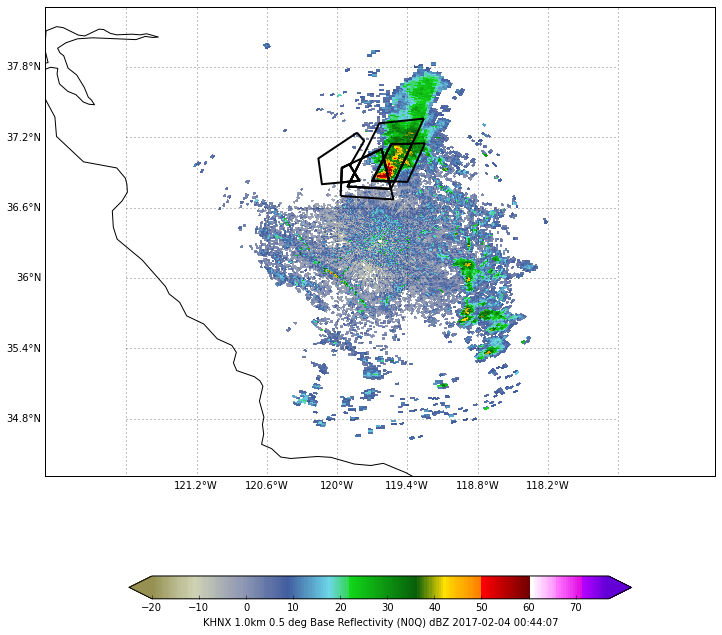

In [14]:
import cartopy.feature as cfeat
from cartopy.feature import ShapelyFeature
from shapely.geometry import Polygon

for rec in grids:
    code = rec["code"]
    bbox = rec["bbox"]
    lats = rec["lats"]
    lons = rec["lons"]
    data = rec["data"]
    # Create figure
    %matplotlib inline
    fig, ax = make_map(bbox=bbox)
    # Colortable filename, beginning value, increment
    ctable = nexrad[code]['ctable'][0]
    beg = nexrad[code]['ctable'][1]
    inc = nexrad[code]['ctable'][2]

    norm, cmap = ctables.registry.get_with_steps(ctable, beg, inc)
    cs = ax.pcolormesh(lons, lats, data, norm=norm, cmap=cmap)
    ax.set_aspect('equal', 'datalim')

    cbar = plt.colorbar(cs, extend='both', shrink=0.75, orientation='horizontal')
    cbar.set_label(site.upper()+" "+ str(nexrad[code]['res']/1000.) +"km " \
                   +nexrad[code]['name']+" ("+code+") " \
                   +nexrad[code]['unit']+" " \
                   +str(record.getDataTime()))

    # Zoom to within +-2 deg of center
    ax.set_xlim(lon-2., lon+2.)
    ax.set_ylim(lat-2., lat+2.)
    for geom in geometries:
        bounds = Polygon(geom)
        intersection = bounds.intersection
        geoms = (intersection(geom)
             for geom in geometries
             if bounds.intersects(geom))

        shape_feature = ShapelyFeature(geoms, ccrs.PlateCarree(), linewidth=2, facecolor='none', edgecolor='black')
        ax.add_feature(shape_feature)
    plt.show()